In [1]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_sp500_tickers():
    """Guncel S&P 500 Listesini cekelim."""

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    tables = pd.read_html(response.text)
    df = tables[0]
    
    tickers = df['Symbol'].tolist()
    # Stock Price isimlendirme duzeltmesi
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

tickers = get_sp500_tickers()
print("",len(tickers), "\n",tickers[:10])

 501 
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [3]:
def download_data(start_date, end_date, tickers):
    """
    Belirtilen tarih araliginda Adjusted Close ve Volume verilerini indirelim.
    """
    print(f"{len(tickers)} hisse icin veri indiriliyor...")

    # yfinance ile verileri indirelim.
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

    prices = data.xs('Close', level=1, axis=1)
    volumes = data.xs('Volume', level=1, axis=1)
    return prices, volumes


# Tarih aralığı
START_DATE = "2010-01-01"
END_DATE   = "2024-12-31"

# S&P 500 güncel tickersları alalım.
tickers = get_sp500_tickers()

# Fiyat ve volume datasını çekelim.
prices_df, volumes_df = download_data(START_DATE, END_DATE, tickers)

# Eksik verisi olan stock price'ları çıkaralım. (Burada survivorship bias oluşturuyoruz ancak bunu raporumuz ekleriz.)
valid_columns = prices_df.columns[prices_df.notna().sum() > (len(prices_df) * 0.8)]
prices_df = prices_df[valid_columns]
volumes_df = volumes_df[valid_columns]

print("Veriler indirildi.")
print(f"prices_df.shape: {prices_df.shape}")
print(prices_df.head())

# prices_df.to_csv("sp500_prices_2010_2024.csv")
# volumes_df.to_csv("sp500_volumes_2010_2024.csv")

501 hisse icin veri indiriliyor...


[**********************74%***********            ]  370 of 501 completed$Q: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[**********************81%**************         ]  406 of 501 completed$SNDK: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*********************100%***********************]  499 of 501 completed$SOLS: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*********************100%***********************]  500 of 501 completed

3 Failed downloads:
['Q', 'SNDK', 'SOLS']: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")


Veriler indirildi.
prices_df.shape: (3773, 446)
Ticker      GNRC    ON        BKNG       ADSK  KMI  TRGP  KKR         EG  \
Date                                                                       
2010-01-04   NaN  8.87  220.354446  25.670000  NaN   NaN  NaN  61.189407   
2010-01-05   NaN  8.79  222.912537  25.280001  NaN   NaN  NaN  60.301464   
2010-01-06   NaN  8.90  215.552979  25.340000  NaN   NaN  NaN  60.279976   
2010-01-07   NaN  8.89  212.650467  25.480000  NaN   NaN  NaN  60.401718   
2010-01-08   NaN  8.89  212.729218  26.260000  NaN   NaN  NaN  60.294281   

Ticker             PG       CTSH  ...        CME        CAH       STLD  \
Date                              ...                                    
2010-01-04  38.417027  20.745398  ...  36.433636  21.679621  12.741956   
2010-01-05  38.429592  20.980341  ...  36.403828  21.486361  12.665320   
2010-01-06  38.247322  20.980341  ...  36.156963  21.133133  13.584909   
2010-01-07  38.039909  20.186872  ...  36.201653 

**calculate_returns** fonksiyonunda değişiklik yapıldı.

- Önceden bir satırda herhangi bir stock_price'ta NaN varsa tüm güne ait datalar siliniyordu, bu doğru bir yaklaşım değilmiş.

```
def calculate_returns(prices_df):
    returns = np.log(prices_df / prices_df.shift(1))
    return returns.dropna()
```


In [4]:
def calculate_returns(prices_df):
    """
    Log getirileri hesaplar.
    Veri kaybını önlemek için dropna() argümanını değiştiriyoruz.
    """
    returns = np.log(prices_df / prices_df.shift(1))
    
    # Sadece TÜM hisselerin boş olduğu satırları (örn: resmi tatiller) sil.
    # Tek bir hisse eksik diye günü silme.
    return returns.dropna(how='all')

# PCA kodunda PCA oncesi standardization ekledim.
def get_pca_residuals(returns_df, n_components=15, window=252):
    """
    PCA Residuals hesaplar. Veriyi standardize eder (Z-Score), 
    böylece PCA varyans yerine korelasyon yapısını yakalar.
    Makalede genellikle n_components 10-50 arası denenir (Guijarro et al. 15-50 arası kullanıyor).
    """

    residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    # Performans için numpy array'e çevirip işlem yapacağız, sonra dataframe'e basacağız
    residuals_values = np.full(returns_df.shape, np.nan)
    
    print(f"PCA Residual hesaplanıyor... (Toplam {len(returns_df) - window} gün işlenecek)")
    
    data_values = returns_df.values
    
    # PCA Modeli
    pca = PCA(n_components=n_components)

    for t in range(window, len(returns_df)):
        if t % 500 == 0: print(f"İşlenen gün: {t}")

        # 1. Eğitim Verisi (Geçmiş Window)
        # t dahil DEĞİL (t-window ... t-1) -> Look-ahead bias yok.
        train_data = data_values[t-window : t]
        
        # 2. NaN Kontrolü
        # O pencerede herhangi bir NaN'ı olan hisseyi o gün için dışarıda bırakalım
        valid_idx = ~np.isnan(train_data).any(axis=0)
        
        # O günkü getiri (Target) de NaN olmamalı
        target_valid = ~np.isnan(data_values[t])
        valid_idx = valid_idx & target_valid

        if np.sum(valid_idx) < n_components + 1:
            continue
            
        # Geçerli veriyi seç
        X_train = train_data[:, valid_idx]
        y_test = data_values[t, valid_idx].reshape(1, -1) # Bugünün getirisi
        
        # 3. Standardizasyon (ÖNEMLİ ADIM)
        # PCA'nın scale'den etkilenmemesi için.
        # Mean ve Std'yi sadece TRAIN setten öğreniyoruz.
        scaler_mean = np.mean(X_train, axis=0)
        scaler_std = np.std(X_train, axis=0) + 1e-8 # Sıfıra bölünme hatasını önle
        
        X_train_scaled = (X_train - scaler_mean) / scaler_std
        
        # PCA Fit
        pca.fit(X_train_scaled)
        
        # 4. Tahmin ve Residual
        # Bugünün verisini de AYNI mean/std ile standardize etmeliyiz
        y_test_scaled = (y_test - scaler_mean) / scaler_std
        
        # Faktörlere indirge
        factors = pca.transform(y_test_scaled)
        
        # Geri oluştur (Reconstruct)
        reconstructed_scaled = pca.inverse_transform(factors)
        
        # Scaled Residual
        res_scaled = y_test_scaled - reconstructed_scaled
        
        # Residual'ı tekrar orijinal getiri uzayına (log-return scale) döndür
        # Formül: Res_raw = Res_scaled * std 
        # (Mean eklemeye gerek yok çünkü residual farktır, mean'ler birbirini götürür)
        res_raw = res_scaled * scaler_std
        
        residuals_values[t, valid_idx] = res_raw.flatten()

    residuals_df = pd.DataFrame(residuals_values, index=returns_df.index, columns=returns_df.columns)
    return residuals_df

In [5]:
returns_df = calculate_returns(prices_df)

# Cap outliers
# returns_df = returns_df.clip(lower=returns_df.quantile(0.05), upper=returns_df.quantile(0.95), axis=1)

# Calculate residuals
residuals_df = get_pca_residuals(returns_df, n_components=5, window=252) # window size 252 - 500 denenebilir.

for col in residuals_df.columns:
    residuals_df[col] = residuals_df[col].astype(np.float64)

residuals_df = residuals_df.dropna(how='all')
print(residuals_df.tail())

PCA Residual hesaplanıyor... (Toplam 3520 gün işlenecek)
İşlenen gün: 500
İşlenen gün: 1000
İşlenen gün: 1500
İşlenen gün: 2000
İşlenen gün: 2500
İşlenen gün: 3000
İşlenen gün: 3500
Ticker          GNRC        ON      BKNG      ADSK       KMI      TRGP  \
Date                                                                     
2024-12-23 -0.018813  0.012347 -0.001541 -0.002741  0.003054  0.001229   
2024-12-24 -0.007787  0.010638  0.002091  0.000740  0.000338  0.000960   
2024-12-26  0.007686 -0.013729 -0.005066 -0.004742 -0.002912 -0.014227   
2024-12-27  0.007613 -0.000900 -0.002443  0.004179  0.001963  0.003056   
2024-12-30  0.003141 -0.024547 -0.003257  0.016685  0.007275 -0.000901   

Ticker           KKR        EG        PG      CTSH  ...       CME       CAH  \
Date                                                ...                       
2024-12-23  0.002152  0.008848  0.001645 -0.001737  ... -0.001449  0.002945   
2024-12-24  0.006536 -0.001181  0.001778 -0.003023  ...  0.003

--- Özet İstatistikler ---
Ortalama Varyans Açıklama Oranı (R^2): %48.55
(Yani hisse hareketlerinin %49'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)
Ortalama Piyasa Korelasyonu (Ham Getiri): 0.601
Ortalama Piyasa Korelasyonu (Residuals):  0.004 (Sıfıra yakın olmalı)


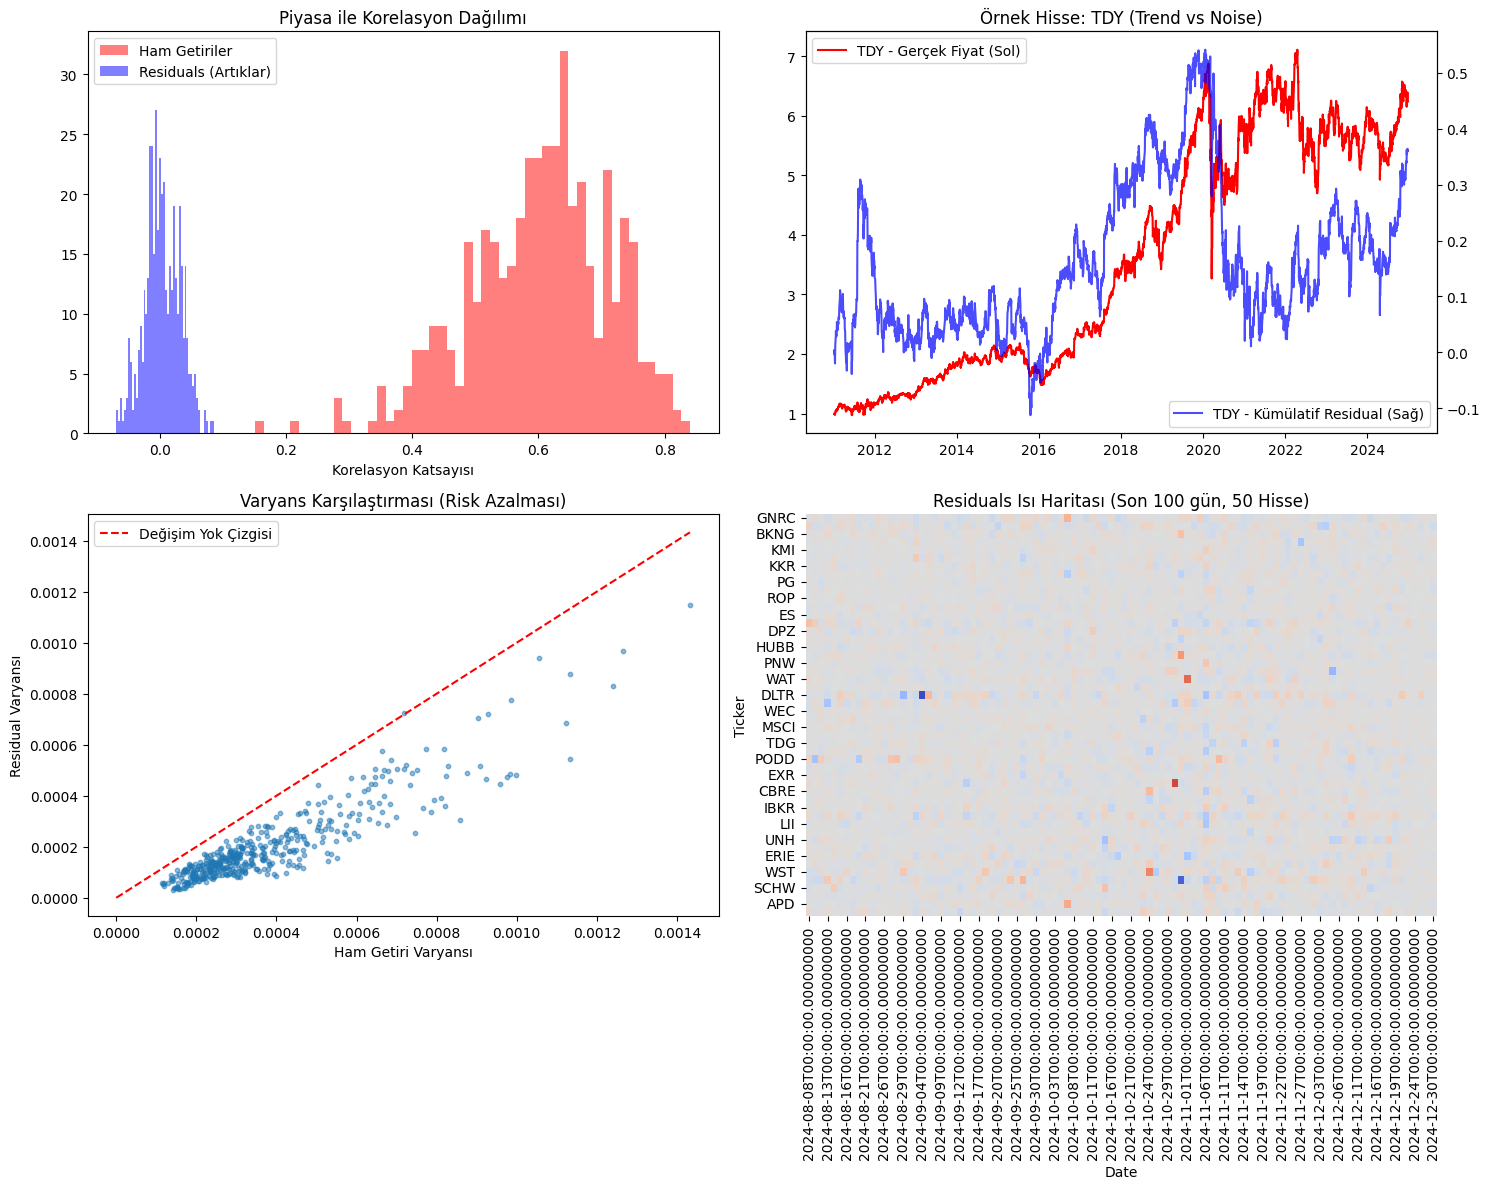

In [6]:
#
def analyze_residuals(returns_df, residuals_df):
    """
    Orijinal getiriler ile PCA sonrası artıkları (residuals) karşılaştırır.
    """
    
    # Ortak tarihleri hizalayalım (Residuals ilk window kadar boştur)
    valid_dates = residuals_df.dropna(how='all').index
    ret_clean = returns_df.loc[valid_dates]
    res_clean = residuals_df.loc[valid_dates]
    
    # Piyasa Proxy'si Oluşturma (Equal Weighted Index)
    # S&P 500 endeks verisi yerine, elimizdeki hisselerin ortalamasını "Piyasa" kabul edelim.
    market_return = ret_clean.mean(axis=1)
    
    # Varyans Azalması (R-Kare Benzeri Analiz)
    # Formül: 1 - (Var(Residual) / Var(Raw))
    # Bu bize "PCA faktörleri varyansın % kaçını açıkladı?" bilgisini verir.
    var_raw = ret_clean.var()
    var_res = res_clean.var()
    variance_explained = 1 - (var_res / var_raw)
    
    print(f"--- Özet İstatistikler ---")
    print(f"Ortalama Varyans Açıklama Oranı (R^2): %{variance_explained.mean()*100:.2f}")
    print(f"(Yani hisse hareketlerinin %{variance_explained.mean()*100:.0f}'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)")
    
    # Piyasa ile Korelasyon Analizi
    # Her bir hissenin piyasa ile korelasyonunu hesapla
    corr_raw = ret_clean.corrwith(market_return)
    corr_res = res_clean.corrwith(market_return)
    
    print(f"Ortalama Piyasa Korelasyonu (Ham Getiri): {corr_raw.mean():.3f}")
    print(f"Ortalama Piyasa Korelasyonu (Residuals):  {corr_res.mean():.3f} (Sıfıra yakın olmalı)")

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafik A: Korelasyon Dağılımı (Histogram)
    axes[0, 0].hist(corr_raw, bins=50, alpha=0.5, label='Ham Getiriler', color='red')
    axes[0, 0].hist(corr_res, bins=50, alpha=0.5, label='Residuals (Artıklar)', color='blue')
    axes[0, 0].set_title('Piyasa ile Korelasyon Dağılımı')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Korelasyon Katsayısı')
    
    # Grafik B: Rastgele Bir Hissenin Kümülatif Getirisi vs Residual
    # Rastgele bir hisse seçelim
    sample_stock = ret_clean.columns[np.random.randint(0, len(ret_clean.columns))]
    
    cum_ret = (1 + ret_clean[sample_stock]).cumprod()
    cum_res = res_clean[sample_stock].cumsum() # Residuals log-return olduğu için toplanır (yaklaşık)
    
    ax2 = axes[0, 1]
    ax2.plot(cum_ret.index, cum_ret, label=f'{sample_stock} - Gerçek Fiyat (Sol)', color='red')
    ax2_r = ax2.twinx()
    ax2_r.plot(cum_res.index, cum_res, label=f'{sample_stock} - Kümülatif Residual (Sağ)', color='blue', alpha=0.7)
    ax2.set_title(f'Örnek Hisse: {sample_stock} (Trend vs Noise)')
    ax2.legend(loc='upper left')
    ax2_r.legend(loc='lower right')
    
    # Grafik C: Volatilite Karşılaştırması
    axes[1, 0].scatter(var_raw, var_res, alpha=0.5, s=10)
    axes[1, 0].plot([0, var_raw.max()], [0, var_raw.max()], 'r--', label='Değişim Yok Çizgisi')
    axes[1, 0].set_title('Varyans Karşılaştırması (Risk Azalması)')
    axes[1, 0].set_xlabel('Ham Getiri Varyansı')
    axes[1, 0].set_ylabel('Residual Varyansı')
    axes[1, 0].legend()
    
    # Grafik D: Residual Isı Haritası (İlk 50 hisse, son 100 gün)
    # Kümeleşme var mı diye bakıyoruz
    import seaborn as sns
    sns.heatmap(res_clean.iloc[-100:, :50].T, ax=axes[1, 1], cmap='coolwarm', center=0, cbar=False)
    axes[1, 1].set_title('Residuals Isı Haritası (Son 100 gün, 50 Hisse)')
    
    plt.tight_layout()
    plt.show()


analyze_residuals(returns_df, residuals_df)

# OU Baseline

Derin öğrenme modelleri (CNN, Transformer), verideki desenleri (pattern) çok iyi öğrenir. Normalizasyon yaptığınızda:

- Deseni Korursunuz: "Fiyat düştü, sonra toparladı" şeklindeki hareketi (V formasyonu gibi) model hala görebilir. Bu harika.

- Genliği (Magnitude) Yok Edersiniz: Hareketin ne kadar şiddetli olduğu bilgisi (standart sapmaya bölündüğü için) kaybolur.Ancak hedef değişkeniniz ($y$) ham getiri olduğu için, genlik bilgisi hayati önem taşır.

Çözüm Nedir?

- Bilgiyi Geri Ver (Benim Önerdiğim):Modele normalize edilmiş grafiği verin (böylece şekli öğrensin), ama yanına ek bir özellik (feature) olarak "Standart Sapma" değerini de verin.
    - Girdi: [Normalize Grafik, 0.01] $\rightarrow$ Model anlar: "Şekil yukarı bakıyor ama katsayısı küçük, tahminim düşük olmalı."
    - Girdi: [Normalize Grafik, 0.10] $\rightarrow$ Model anlar: "Şekil yukarı bakıyor ve katsayısı büyük, tahminim yüksek olmalı."

- Hedefi de Normalize Et (Alternatif): Modelden ham getiriyi ($y$) değil, Sharpe Oranını ($y / \sigma$) tahmin etmesini isteyin.
    - Hisse A Hedefi: $0.005 / 0.01 = 0.5$
    - Hisse B Hedefi: $0.050 / 0.10 = 0.5$
    - Bu durumda model girdileri aynı olduğu için çıktıları da aynı (0.5) tahmin eder ve hata yapmaz. Tahmin sonrası gerçek paraya dönmek için model çıktısını tekrar o günün volatilitesi ile çarparsınız.


Sizin durumunuzda CNN+Transformer kullanacağımız ve makalede genelde Sharpe odaklı gidildiği için, Volatilite bilgisini modele ayrı bir kanal veya feature olarak vermek en sağlam yöntemdir.

In [7]:
from tqdm import tqdm

def create_ou_sequences(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini OU Modeli için hazırlar.
    DEĞİŞİKLİKLER:
    1. Veri kümülatif toplama (Fiyat serisi) çevrildi.
    2. Normalizasyon KALDIRILDI (OU kendi parametrelerini tahmin etmeli).
    3. Çıktı boyutu (Samples, Window) yapıldı (3D gerekmez).
    """
    
    # 1. Adım: Residual'ları Kümülatif Fiyata Çevir (OU Seviye Bazlıdır)
    # NaN'ları 0 ile dolduruyoruz ki kümülatif toplam bozulmasın.
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    # DataFrame'i Numpy'a çevir
    data = prices_df.values
    num_days, num_stocks = data.shape
    
    X_list = []
    y_list = [] # OU için aslında 'y' (target) gerekmez ama backtest için sonraki günün getirisini tutalım.
    
    # Residuals DF orijinal halini de alalım (Target hesabı için günlük getiri lazım)
    raw_residuals = residuals_df.fillna(0.0).values
    
    print(f"OU Veri Seti oluşturuluyor... (Hisse: {num_stocks}, Gün: {num_days})")
    
    # Her hisse için döngü
    for stock_idx in tqdm(range(num_stocks)):
        stock_prices = data[:, stock_idx]
        stock_daily_ret = raw_residuals[:, stock_idx]
        
        # Kayan Pencere (Rolling Window)
        for t in range(window_size, num_days):
            
            # Girdi: t-60'dan t'ye kadar olan KÜMÜLATİF FİYAT serisi
            # OU parametreleri (kappa, sigma) bu seriden hesaplanacak.
            input_window = stock_prices[t-window_size : t]
            
            # Hedef: t anındaki (bir sonraki günün) GÜNLÜK GETİRİSİ
            # (P&L hesabı için saklıyoruz)
            target = stock_daily_ret[t]
            
            # --- NORMALİZASYON YOKTUR ---
            # OU formülü ham varyansı kullanır.
            
            X_list.append(input_window)
            y_list.append(target)

    # Listeleri Numpy Array'e çevir
    # Deep Learning olmadığı için float64 hassasiyeti OU için daha iyidir (matris tersi vb. için)
    X = np.array(X_list, dtype=np.float64)
    y = np.array(y_list, dtype=np.float64)
    
    # OU fonksiyonları genelde 1D array bekler, o yüzden 3. boyutu (channel) EKLEMİYORUZ.
    # X Shape: (Samples, 60)
    
    return X, y

# --- UYGULAMA ---
# OU literatüründe genelde 60 gün (yaklaşık 3 ay) kullanılır.
X_ou, y_ou = create_ou_sequences(residuals_df, window_size=30)

print(f"\nOU Veri Seti Hazırlandı!")
print(f"Girdi Boyutu (X): {X_ou.shape}") # Örn: (Samples, 60)
print(f"Hedef Boyutu (y): {y_ou.shape}") # Örn: (Samples,)

# Örnek Kontrol: İlk pencerenin varyansı 1 OLMAMALI (Doğal varyans olmalı)
print(f"İlk pencere varyansı: {np.var(X_ou[0]):.6f} (Sıfırdan ve Birden farklı olmalı)")

OU Veri Seti oluşturuluyor... (Hisse: 446, Gün: 3520)


100%|██████████| 446/446 [00:00<00:00, 1881.45it/s]



OU Veri Seti Hazırlandı!
Girdi Boyutu (X): (1556540, 30)
Hedef Boyutu (y): (1556540,)
İlk pencere varyansı: 0.000174 (Sıfırdan ve Birden farklı olmalı)


In [8]:
# ============================================================================
# ORNSTEIN-UHLENBECK (OU) MODEL BENCHMARK
# Makale: Section II.D.1, Avellaneda & Lee (2010), Yeo & Papanicolaou (2017)
# ============================================================================
import torch
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score

def estimate_ou_parameters(cumulative_residuals):
    """
    Ornstein-Uhlenbeck process parametrelerini moment-based estimation ile tahmin eder.
    
    OU Process: dX_t = κ(μ - X_t)dt + σdB_t
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals time series (L uzunluğunda)
    
    Returns:
    --------
    kappa : float
        Mean reversion speed
    mu : float
        Long-term mean
    sigma : float
        Volatility
    r2 : float
        Goodness of fit (R²)
    """
    x = cumulative_residuals
    L = len(x)
    
    if L < 3:
        return 0.1, np.mean(x), np.std(x), 0.0
    
    # Discrete-time OU process: X_{t+1} = X_t + κ(μ - X_t)Δt + σ√Δt * ε
    # Δt = 1 (daily)
    # Moment-based estimation (makale Appendix B.B)
    
    # First moment: E[X] = μ
    mu = np.mean(x)
    
    # Second moment: Var[X] = σ² / (2κ)
    # Autocovariance: Cov[X_t, X_{t+1}] = Var[X] * exp(-κ)
    
    # Variance
    var_x = np.var(x, ddof=1)
    
    # Autocovariance (lag 1)
    if L > 1:
        x_centered = x - mu
        autocov = np.mean(x_centered[:-1] * x_centered[1:])
    else:
        autocov = 0
    
    # Estimate κ from autocorrelation
    if var_x > 1e-10:
        rho = autocov / var_x  # Autocorrelation
        # rho = exp(-κ) => κ = -log(rho)
        kappa = max(0.01, -np.log(max(0.01, min(0.99, rho))))  # Clamp to avoid numerical issues
    else:
        kappa = 0.1
    
    # Estimate σ from variance: Var[X] = σ² / (2κ)
    if kappa > 1e-10:
        sigma = np.sqrt(2 * kappa * var_x)
    else:
        sigma = np.std(x)
    
    # R² calculation (goodness of fit)
    # Predict X_{t+1} = X_t + κ(μ - X_t)
    if L > 1:
        x_pred = x[:-1] + kappa * (mu - x[:-1])
        x_actual = x[1:]
        r2 = r2_score(x_actual, x_pred)
        r2 = max(0.0, min(1.0, r2))  # Clamp between 0 and 1
    else:
        r2 = 0.0
    
    return kappa, mu, sigma, r2

def ou_signal_extraction(cumulative_residuals):
    """
    OU model için signal extraction.
    Makale: θ^OU = [κ̂, μ̂, σ̂, X_L, R²]
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals (L uzunluğunda)
    
    Returns:
    --------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    """
    kappa, mu, sigma, r2 = estimate_ou_parameters(cumulative_residuals)
    x_L = cumulative_residuals[-1]  # Son değer
    
    return np.array([kappa, mu, sigma, x_L, r2])

def ou_allocation_function(signal, c_thresh=1.0, c_crit=0.1):
    """
    OU model için threshold-based allocation function.
    Makale: w^ε = -1 if (X_L - μ) / (σ/√(2κ)) > c_thresh and R² > c_crit
             w^ε = 1 if (X_L - μ) / (σ/√(2κ)) < -c_thresh and R² > c_crit
             w^ε = 0 otherwise
    
    Parameters:
    -----------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    c_thresh : float
        Threshold parameter (default: 1.0)
    c_crit : float
        Critical R² value (default: 0.1)
    
    Returns:
    --------
    weight : float
        Allocation weight (-1, 0, or 1)
    """
    kappa, mu, sigma, x_L, r2 = signal
    
    # Avoid division by zero
    if kappa < 1e-10 or sigma < 1e-10:
        return 0.0
    
    # Normalized deviation
    z_score = (x_L - mu) / (sigma / np.sqrt(2 * kappa))
    
    # Threshold rule
    if r2 > c_crit:
        if z_score > c_thresh:
            return -1.0  # Sell (expect mean reversion down)
        elif z_score < -c_thresh:
            return 1.0   # Buy (expect mean reversion up)
    
    return 0.0  # No position

def ou_model_predict(X_test, y_test, c_thresh=1.0, c_crit=0.1):
    """
    OU model ile tüm test seti için tahmin yapar.
    
    Parameters:
    -----------
    X_test : torch.Tensor or np.array
        Test features (Batch, L, 1) - cumulative residuals
    y_test : torch.Tensor or np.array
        Test targets (Batch,)
    c_thresh : float
        Threshold parameter
    c_crit : float
        Critical R² value
    
    Returns:
    --------
    predictions : np.array
        Predicted weights
    actual_returns : np.array
        Actual returns
    """
    # Convert to numpy if needed
    if isinstance(X_test, torch.Tensor):
        X_test = X_test.cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    
    # Reshape if needed: (Batch, L, 1) -> (Batch, L)
    if X_test.ndim == 3:
        X_test = X_test.squeeze(-1)
    
    predictions = []
    actual_returns = []
    
    for i in range(len(X_test)):
        cumulative_residuals = X_test[i]
        
        # Extract signal
        signal = ou_signal_extraction(cumulative_residuals)
        
        # Get allocation
        weight = ou_allocation_function(signal, c_thresh=c_thresh, c_crit=c_crit)
        
        predictions.append(weight)
        actual_returns.append(y_test[i])
    
    return np.array(predictions), np.array(actual_returns)

'''# Test OU Model
print("=== OU MODEL BENCHMARK ===")
print("OU model parametreleri tahmin ediliyor...")

# Test setinde OU model ile tahmin yap
ou_predictions, ou_actual = ou_model_predict(X_ou[:1000], y_ou[:1000], c_thresh=1.0, c_crit=0.1)

# Performance hesapla
ou_returns = ou_predictions * ou_actual
ou_sharpe = np.mean(ou_returns) / (np.std(ou_returns) + 1e-6) * np.sqrt(252)
ou_total_return = np.sum(ou_returns)

print(f"OU Model Test (1000 örnek):")
print(f"  Sharpe Ratio (annualized): {ou_sharpe:.4f}")
print(f"  Total Return: {ou_total_return:.4f}")
print(f"  Mean Return: {np.mean(ou_returns):.6f}")
print(f"  Std Return: {np.std(ou_returns):.6f}")'''

'# Test OU Model\nprint("=== OU MODEL BENCHMARK ===")\nprint("OU model parametreleri tahmin ediliyor...")\n\n# Test setinde OU model ile tahmin yap\nou_predictions, ou_actual = ou_model_predict(X_ou[:1000], y_ou[:1000], c_thresh=1.0, c_crit=0.1)\n\n# Performance hesapla\nou_returns = ou_predictions * ou_actual\nou_sharpe = np.mean(ou_returns) / (np.std(ou_returns) + 1e-6) * np.sqrt(252)\nou_total_return = np.sum(ou_returns)\n\nprint(f"OU Model Test (1000 örnek):")\nprint(f"  Sharpe Ratio (annualized): {ou_sharpe:.4f}")\nprint(f"  Total Return: {ou_total_return:.4f}")\nprint(f"  Mean Return: {np.mean(ou_returns):.6f}")\nprint(f"  Std Return: {np.std(ou_returns):.6f}")'

Veri Kesiti Alınıyor: 2021-09-01 (Buffer) -> 2024-12-31
Test dönemi için diziler oluşturuluyor...
OU Veri Seti oluşturuluyor... (Hisse: 446, Gün: 837)


100%|██████████| 446/446 [00:00<00:00, 8477.30it/s]


=== 2022-2024 DÖNEMİ OU TEST SONUÇLARI ===


Dönem: 2022-01-01 - 2024-12-31
İşlem Yapılan Gün/Hisse Sayısı: 359922
Sharpe Ratio: 0.0881
Toplam Getiri (Log): 19.4080
Win Rate (Kazanç Oranı): %50.49


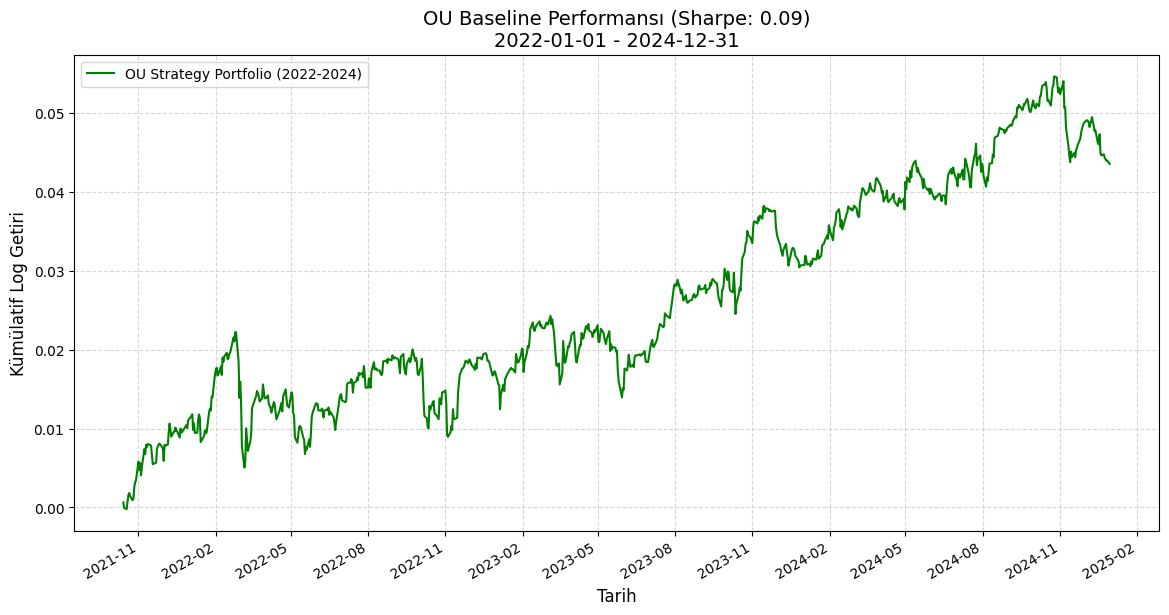

In [9]:
import matplotlib.dates as mdates

# -------------------------------------------------------------------------
# ADIM 1: Tarih Bazlı Veri Süzme (2022-2024 Dönemi)
# -------------------------------------------------------------------------

# Test etmek istediğin aralık
TEST_START_DATE = "2022-01-01"
TEST_END_DATE   = "2024-12-31"
WINDOW_SIZE = 30

# OU modeli 60 gün geriye baktığı için, veriyi biraz daha erkenden başlatıyoruz.
# Yaklaşık 3-4 ay (90 iş günü) geriden alalım ki 1 Ocak 2022'de sinyal üretmeye başlasın.
buffer_start_date = pd.to_datetime(TEST_START_DATE) - pd.DateOffset(months=4)

print(f"Veri Kesiti Alınıyor: {buffer_start_date.date()} (Buffer) -> {TEST_END_DATE}")

# residuals_df'in index'i datetime formatında olmalı. Değilse çevir:
if not isinstance(residuals_df.index, pd.DatetimeIndex):
    residuals_df.index = pd.to_datetime(residuals_df.index)

# Sadece ilgili tarih aralığındaki veriyi kesip alıyoruz
df_test_period = residuals_df.loc[buffer_start_date : TEST_END_DATE]

# -------------------------------------------------------------------------
# ADIM 2: Seçilen Dönem İçin Veri Seti Oluşturma (create_ou_sequences ile)
# -------------------------------------------------------------------------
# Daha önce tanımladığımız create_ou_sequences fonksiyonunu kullanıyoruz.
# Bu fonksiyon veriyi senin OU modelinin istediği formata (Prices, Returns) çevirir.

print("Test dönemi için diziler oluşturuluyor...")
X_test_22_24, y_test_22_24 = create_ou_sequences(df_test_period, window_size=WINDOW_SIZE)

# -------------------------------------------------------------------------
# ADIM 3: Model Tahmini ve Sonuçlar
# -------------------------------------------------------------------------
print("\n=== 2022-2024 DÖNEMİ OU TEST SONUÇLARI ===")

# Model Tahminini Çalıştır (Senin fonksiyonun)
# c_thresh=1.25, c_crit=0.05 makalede önerilen sıkı parametrelerdir.
preds, actuals = ou_model_predict(X_test_22_24, y_test_22_24, c_thresh=1.25, c_crit=0.05)

# P&L Hesaplama
# returns = Pozisyon * Gerçekleşen Getiri
period_returns = preds * actuals

# Metrikler
annual_factor = np.sqrt(252)
sharpe = np.mean(period_returns) / (np.std(period_returns) + 1e-8) * annual_factor
total_ret = np.sum(period_returns)
win_rate = np.sum(period_returns > 0) / (np.sum(period_returns != 0) + 1e-8)

print(f"Dönem: {TEST_START_DATE} - {TEST_END_DATE}")
print(f"İşlem Yapılan Gün/Hisse Sayısı: {len(period_returns)}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Toplam Getiri (Log): {total_ret:.4f}")
print(f"Win Rate (Kazanç Oranı): %{win_rate*100:.2f}")

# -------------------------------------------------------------------------
# ADIM 4: Tarih Bazlı Görselleştirme (DÜZENLENDİ)
# -------------------------------------------------------------------------

# 1. Tarihleri Yeniden Oluşturma (Mapping)
# create_ou_sequences fonksiyonu veriyi "Hisse Bazlı" (Önce Hisse A'nın tüm günleri, Sonra Hisse B...) dizer.
# Ancak her hisse için zaman penceresi aynıdır: [window_size : end]
valid_dates = df_test_period.index[WINDOW_SIZE:] # window_size=60 olduğu için ilk 60 gün yok

# Kaç hisse olduğunu bulalım
num_stocks = df_test_period.shape[1]

# Tarihleri hisse sayısı kadar tekrarla (Model çıktısıyla aynı sıraya getirmek için)
# Örn: [Tarih1..TarihN, Tarih1..TarihN, ...]
date_index = np.tile(valid_dates, num_stocks)

# 2. DataFrame Oluşturma ve Günlük Bazda Gruplama
# Tahmin edilen getirileri tarihlerle eşleştiriyoruz
df_pnl = pd.DataFrame({
    'Date': date_index,
    'Return': period_returns
})

# Aynı güne ait tüm hisse getirilerinin ortalamasını alıyoruz (Equal Weighted Portfolio)
# Not: Eğer sermayeyi böldüyseniz .sum() da kullanılabilir, ama performans görmek için .mean() standarttır.
daily_portfolio_returns = df_pnl.groupby('Date')['Return'].mean()

# 3. Kümülatif Getiri (Time Series)
cumulative_pnl_dated = daily_portfolio_returns.cumsum()

# 4. Grafik Çizimi
plt.figure(figsize=(14, 7))

# Kümülatif getiriyi çiz
plt.plot(cumulative_pnl_dated.index, cumulative_pnl_dated.values, 
         label='OU Strategy Portfolio (2022-2024)', color='green', linewidth=1.5)

# Tarih formatlama (X eksenini güzelleştirme)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # 3 ayda bir tarih yaz

plt.title(f'OU Baseline Performansı (Sharpe: {sharpe:.2f})\n{TEST_START_DATE} - {TEST_END_DATE}', fontsize=14)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Kümülatif Log Getiri', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.gcf().autofmt_xdate() # Tarihleri eğik yazarak okunurluğu artır

plt.show()

## XGBOOST

In [11]:
# XGBOOST FEATURE ENGINEERING

def calculate_rsi_numpy(series, period=14):
    """
    Pandas TA kütüphanesine ihtiyaç duymadan RSI hesaplar.
    """
    delta = series.diff()
    
    # Pozitif ve Negatif farkları ayır
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    # RS Hesapla
    rs = gain / (loss + 1e-8) # Sıfıra bölünme hatasını önlemek için 1e-8 ekledik
    
    # RSI Formülü: 100 - (100 / (1 + RS))
    return 100 - (100 / (1 + rs))

def prepare_xgboost_features(residuals_df):
    """
    Residuals DataFrame'inden XGBoost için denetimli öğrenme (supervised) veri seti çıkarır.
    """
    print("XGBoost için Feature Engineering yapılıyor...")
    
    # 1. Hazırlık: Residual'ları Kümülatif Fiyata Çevir (İndikatörler buna uygulanacak)
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    features_list = []
    
    # Farklı zaman pencereleri (Kısa, Orta, Uzun Vade)
    windows = [10, 30, 60]
    lags = [1,2,3, 5, 10, 20, 30]

    # İlerlemeyi görmek için tqdm
    for ticker in tqdm(residuals_df.columns):
        
        # O hissenin verilerini al
        res_ret = residuals_df[ticker]   # Günlük Residual Getiri
        res_price = prices_df[ticker]    # Kümülatif Fiyat (Level)
        
        # Geçici DataFrame
        df = pd.DataFrame(index=residuals_df.index)
        
        # --- FEATURE 1: Lags (Geçmiş Getiriler) ---
        # Modelin "dün ne kadar oynadı?" bilgisini görmesi için
        for lag in lags:
            df[f'lag_{lag}'] = res_ret.shift(lag)

        # --- FEATURE 2 & 3 & 4: Rolling Stats (Mean Rev, Volatilite, Momentum) ---
        for w in windows:
            # Hareketli Ortalama ve Sapma
            # İşlemi "bugün kapanışta" yapıp "yarını" tahmin edeceğimiz için
            # bugünün değerlerini kullanmakta sakınca yok (Target shift(-1) olacak).
            
            roll_mean = res_price.rolling(window=w).mean()
            roll_std = res_price.rolling(window=w).std()
            
            # Z-Score (O-U Sinyali): (Fiyat - Ort) / Std
            df[f'zscore_{w}'] = (res_price - roll_mean) / (roll_std + 1e-8)
            
            # Volatilite (Scale Bilgisi - KRİTİK)
            df[f'vol_{w}'] = roll_std
            
            # Momentum: Fiyat - Fiyat(t-w)
            df[f'mom_{w}'] = res_price - res_price.shift(w)
            
            # Fiyatın hareketli ortalamaya uzaklığı (Mutlak fark)
            df[f'dist_ma_{w}'] = res_price - roll_mean

        # --- FEATURE 5: RSI (Teknik İndikatör) ---
        # Kendi yazdığımız fonksiyonu kullanıyoruz
        df['rsi_14'] = calculate_rsi_numpy(res_price, period=14)
        
        # --- TARGET (HEDEF DEĞİŞKEN) ---
        # Neyi tahmin ediyoruz? -> BİR SONRAKİ GÜNÜN Getirisini.
        df['target_return'] = res_ret.shift(-1)
        
        # NaN Temizliği
        df = df.dropna()
        
        # Listeye ekle
        features_list.append(df)
    
    # Tüm hisseleri alt alta (vstack) birleştir
    full_dataset = pd.concat(features_list)
    
    # Bellek optimizasyonu (Float64 -> Float32)
    full_dataset = full_dataset.astype(np.float32)
    
    return full_dataset

# --- ÇALIŞTIRMA ---
xgb_dataset = prepare_xgboost_features(residuals_df)

print("\nXGBoost Veri Seti Hazır!")
print(f"Boyutlar: {xgb_dataset.shape}")
print("\nSütunlar (Features):")
print(xgb_dataset.columns.tolist())
print("\nİlk 5 Satır:")
print(xgb_dataset.head())

XGBoost için Feature Engineering yapılıyor...


100%|██████████| 446/446 [00:01<00:00, 346.87it/s]



XGBoost Veri Seti Hazır!
Boyutlar: (1533929, 21)

Sütunlar (Features):
['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_20', 'lag_30', 'zscore_10', 'vol_10', 'mom_10', 'dist_ma_10', 'zscore_30', 'vol_30', 'mom_30', 'dist_ma_30', 'zscore_60', 'vol_60', 'mom_60', 'dist_ma_60', 'rsi_14', 'target_return']

İlk 5 Satır:
               lag_1     lag_2     lag_3     lag_5    lag_10    lag_20  \
Date                                                                     
2011-03-31  0.000949 -0.007674 -0.003461 -0.013383 -0.005426  0.002720   
2011-04-01  0.009912  0.000949 -0.007674 -0.005825  0.012112 -0.013710   
2011-04-04 -0.009009  0.009912  0.000949 -0.003461  0.004524 -0.002100   
2011-04-05 -0.001406 -0.009009  0.009912 -0.007674  0.005705  0.011353   
2011-04-06 -0.002225 -0.001406 -0.009009  0.000949 -0.011963  0.006860   

              lag_30  zscore_10    vol_10    mom_10  ...  zscore_30    vol_30  \
Date                                                 ...                       

In [10]:
# DATASET FOR ADVANCED XGBOOST FEATURES

def calculate_rsi_numpy(series, period=14):
    """ Mevcut RSI Fonksiyonunuz """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

def prepare_advanced_xgboost_features(residuals_df):
    """
    GELİŞTİRİLMİŞ FEATURE SETİ:
    - Skewness & Kurtosis (Dağılım bozulmalarını yakalar)
    - Volatility Ratios (Rejim değişikliklerini yakalar)
    - Bollinger Band Width (Sıkışmaları yakalar)
    """
    print("Gelişmiş XGBoost Feature Engineering yapılıyor...")
    
    # Kümülatif Fiyatlar
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    features_list = []
    
    # Pencereler
    windows = [10, 30, 60]
    lags = [1, 2, 3, 5, 10, 20, 30]
    
    for ticker in tqdm(residuals_df.columns):
        
        res_ret = residuals_df[ticker]
        res_price = prices_df[ticker]
        
        df = pd.DataFrame(index=residuals_df.index)
        
        # --- MEVCUT FEATURES (Temel) ---
        for lag in lags:
            df[f'lag_{lag}'] = res_ret.shift(lag)
            
        df['rsi_14'] = calculate_rsi_numpy(res_price, period=14)
        
        # --- YENİ & GELİŞMİŞ FEATURES ---
        for w in windows:
            roll_mean = res_price.rolling(window=w).mean()
            roll_std  = res_price.rolling(window=w).std()
            
            # 1. Z-Score (Klasik)
            df[f'zscore_{w}'] = (res_price - roll_mean) / (roll_std + 1e-8)
            
            # 2. Volatilite (Klasik)
            df[f'vol_{w}'] = roll_std
            
            # 3. YENİ: Skewness (Çarpıklık)
            # Modelin "Bu hareket normal mi yoksa bir haber mi geldi?" ayrımı yapmasını sağlar.
            # En az 20 gün veri gerekir, o yüzden w < 20 ise atlayabiliriz veya 20 yaparız.
            if w >= 30: 
                df[f'skew_{w}'] = res_price.rolling(window=w).skew()
                df[f'kurt_{w}'] = res_price.rolling(window=w).kurt()
            
            # 4. YENİ: Bollinger Band Width (BBW)
            # Bantlar ne kadar geniş? Geniş bant = Yüksek Risk/Fırsat
            upper = roll_mean + (2 * roll_std)
            lower = roll_mean - (2 * roll_std)
            df[f'bb_width_{w}'] = (upper - lower) / (roll_mean + 1e-8)
            
            # 5. YENİ: Distance to Max/Min (Son w gündeki zirveye/dibe uzaklık)
            # Mean Reversion için kritik: "Dibe ne kadar yakınız?"
            roll_max = res_price.rolling(window=w).max()
            roll_min = res_price.rolling(window=w).min()
            
            # (Fiyat - Min) / (Max - Min) -> Stokastik Osilatör Mantığı
            df[f'stoch_{w}'] = (res_price - roll_min) / (roll_max - roll_min + 1e-8)

        # 6. YENİ: Volatility Ratio (Kısa Vade / Uzun Vade)
        # Volatilite artıyor mu azalıyor mu?
        # 10 günlük vol / 60 günlük vol
        vol_10 = res_price.rolling(window=10).std()
        vol_60 = res_price.rolling(window=60).std()
        df['vol_ratio'] = vol_10 / (vol_60 + 1e-8)
        
        # 7. YENİ: Time Features (Zamanlama)
        # One-Hot Encoding yerine Tree modelleri için Ordinal (0-4) yeterlidir.
        #df['day_of_week'] = df.index.dayofweek # 0=Pzt, 4=Cuma
        #df['month_of_year'] = df.index.month
        
        # --- TARGET ---
        df['target_return'] = res_ret.shift(-1)
        
        df = df.dropna()
        features_list.append(df)
    
    full_dataset = pd.concat(features_list)
    full_dataset = full_dataset.astype(np.float32)
    
    return full_dataset

# Kodu Çalıştır
xgb_dataset = prepare_advanced_xgboost_features(residuals_df)

print("\nGelişmiş Veri Seti Hazır!")
print(f"Yeni Boyutlar: {xgb_dataset.shape}")
print("Örnek Feature İsimleri:", xgb_dataset.columns[:10].tolist())

Gelişmiş XGBoost Feature Engineering yapılıyor...


100%|██████████| 446/446 [00:02<00:00, 213.97it/s]



Gelişmiş Veri Seti Hazır!
Yeni Boyutlar: (1534351, 26)
Örnek Feature İsimleri: ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_20', 'lag_30', 'rsi_14', 'zscore_10', 'vol_10']


Veri Seti Yılları: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Strateji: 6 Yıl Eğitim -> 1 Yıl Doğrulama (Kaydırmalı)

--- FOLD: Train [2011-2016] | Val [2017] ---
   TRAIN Başarısı -> Sharpe: 1.0139 | İşlem Sayısı: 28751
   VAL   Başarısı -> Sharpe: 0.0873   | İşlem Sayısı: 3727
   Durum: Normal

--- FOLD: Train [2012-2017] | Val [2018] ---
   TRAIN Başarısı -> Sharpe: 0.9815 | İşlem Sayısı: 25767
   VAL   Başarısı -> Sharpe: 0.0873   | İşlem Sayısı: 5030
   Durum: Normal

--- FOLD: Train [2013-2018] | Val [2019] ---
   TRAIN Başarısı -> Sharpe: 0.9484 | İşlem Sayısı: 24990
   VAL   Başarısı -> Sharpe: -0.0097   | İşlem Sayısı: 4746
   Durum: Normal

--- FOLD: Train [2014-2019] | Val [2020] ---
   TRAIN Başarısı -> Sharpe: 0.8676 | İşlem Sayısı: 21569
   VAL   Başarısı -> Sharpe: -0.0130   | İşlem Sayısı: 13688
   Durum: Normal

--- FOLD: Train [2015-2020] | Val [2021] ---
   TRAIN Başarısı -> Sharpe: 0.9425 | İşlem Sayısı: 29652
   VAL   Başarısı ->

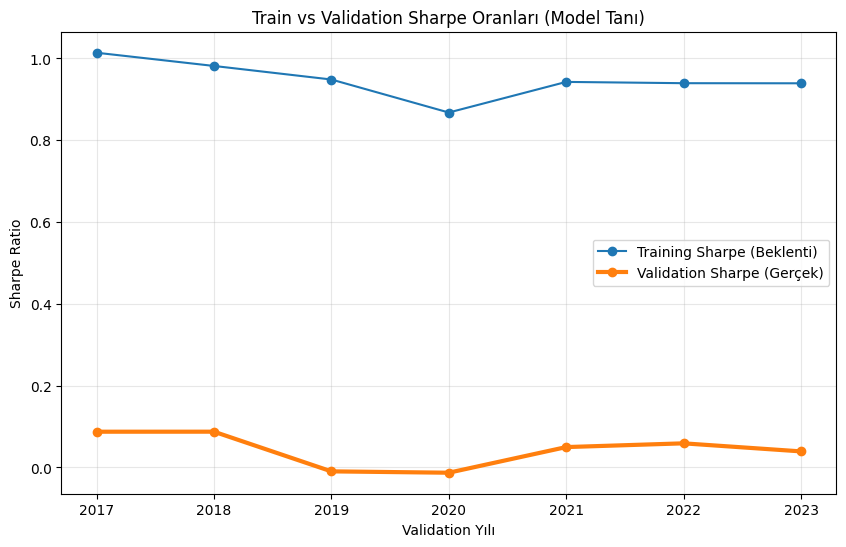

In [12]:
# XGBOOST RAW MODEL
import xgboost as xgb

# ==========================================================
# AYARLAR: 6 Yıl Train + 1 Yıl Validation (Rolling)
# ==========================================================
TRAIN_WINDOW = 6 
VAL_WINDOW   = 1

# Veri setindeki mevcut yılları alalım
all_years = sorted(xgb_dataset.index.year.unique().tolist()[:-1]) # Son yılı çıkar (TEST PERIYODUMUZ OLARAK KALACAK)

# Başlangıç yılı (Veri setinizin en başı)
start_year = all_years[0] 

print(f"Veri Seti Yılları: {all_years}")
print(f"Strateji: {TRAIN_WINDOW} Yıl Eğitim -> {VAL_WINDOW} Yıl Doğrulama (Kaydırmalı)")

# Feature ve Target sütunlarını belirle
feature_cols = [c for c in xgb_dataset.columns if c != 'target_return']
target_col   = 'target_return'

# ==========================================================
# ROLLING WALK-FORWARD ANALİZİ
# ==========================================================
results_log = []

# Döngü mantığı:
# Elimizdeki veri bitene kadar pencereyi kaydıracağız.
# Train başlangıç yılından itibaren döngü kuruyoruz.

current_train_start = start_year

while True:
    # Yıl sınırlarını belirle
    current_train_end = current_train_start + TRAIN_WINDOW - 1
    current_val_year  = current_train_end + 1
    
    # Eğer validasyon yılı veri setindeki son yılı aşıyorsa döngüyü bitir
    if current_val_year > all_years[-1]:
        break
        
    print(f"\n--- FOLD: Train [{current_train_start}-{current_train_end}] | Val [{current_val_year}] ---")
    
    # --- 1. Veri Dilimleme (Slicing) ---
    train_mask = (xgb_dataset.index.year >= current_train_start) & (xgb_dataset.index.year <= current_train_end)
    val_mask   = (xgb_dataset.index.year == current_val_year)
    
    X_train = xgb_dataset.loc[train_mask, feature_cols]
    y_train = xgb_dataset.loc[train_mask, target_col]
    
    X_val   = xgb_dataset.loc[val_mask, feature_cols]
    y_val   = xgb_dataset.loc[val_mask, target_col]
    
    # --- 2. Baseline Model Kurulumu (Tuning Yok) ---
    # Standart parametreler: Derinlik 5, Learning Rate 0.05
    model = xgb.XGBRegressor(
        n_estimators=200,      
        learning_rate=0.05,    
        max_depth=5,           
        subsample=0.8,         
        colsample_bytree=0.8,  
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    )
    
    # Modeli Eğit
    model.fit(X_train, y_train)
    
    # --- 3. Performans Ölçümü (Train vs Val) ---
    
    # Tahminler
    preds_train = model.predict(X_train)
    preds_val   = model.predict(X_val)
    
    # Sinyal Üretimi (Threshold = 0.001)
    threshold = 0.001
    
    # Train Skorları
    sig_train = np.zeros_like(preds_train)
    sig_train[preds_train > threshold] = 1
    sig_train[preds_train < -threshold] = -1
    ret_train = sig_train * y_train.values
    sharpe_train = np.mean(ret_train) / (np.std(ret_train) + 1e-8) * np.sqrt(252)
    
    # Validation Skorları
    sig_val = np.zeros_like(preds_val)
    sig_val[preds_val > threshold] = 1
    sig_val[preds_val < -threshold] = -1
    ret_val = sig_val * y_val.values
    sharpe_val = np.mean(ret_val) / (np.std(ret_val) + 1e-8) * np.sqrt(252)
    
    # Çıktı Yazdır
    print(f"   TRAIN Başarısı -> Sharpe: {sharpe_train:.4f} | İşlem Sayısı: {np.sum(sig_train!=0)}")
    print(f"   VAL   Başarısı -> Sharpe: {sharpe_val:.4f}   | İşlem Sayısı: {np.sum(sig_val!=0)}")
    
    # Fark Analizi
    diff = sharpe_train - sharpe_val
    status = "Normal"
    if diff > 2.0: status = "OVERFITTING (Ezberleme)"
    if sharpe_train < 0.5: status = "UNDERFITTING (Öğrenememe)"
    
    print(f"   Durum: {status}")
    
    # Kayıt
    results_log.append({
        'Train_Years': f"{current_train_start}-{current_train_end}",
        'Val_Year': current_val_year,
        'Train_Sharpe': sharpe_train,
        'Val_Sharpe': sharpe_val
    })
    
    # Bir sonraki fold için başlangıcı 1 yıl kaydır
    current_train_start += 1

# --- ÖZET TABLO ---
print("\n=== ÖZET RAPOR ===")
df_results = pd.DataFrame(results_log)
print(df_results)

# Grafiksel Karşılaştırma
plt.figure(figsize=(10, 6))
plt.plot(df_results['Val_Year'].astype(str), df_results['Train_Sharpe'], marker='o', label='Training Sharpe (Beklenti)')
plt.plot(df_results['Val_Year'].astype(str), df_results['Val_Sharpe'], marker='o', label='Validation Sharpe (Gerçek)', linewidth=3)
plt.title('Train vs Validation Sharpe Oranları (Model Tanı)')
plt.xlabel('Validation Yılı')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

EARLY STOPPING yerine N_ESTIMATORS parametresini tarayarak.

In [33]:
import optuna
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1. VERİ HAZIRLIĞI (2011 - 2023)
# ==========================================================
OPT_START_YEAR = 2011
OPT_END_YEAR   = 2023 

print(f"Optimizasyon Havuzu: {OPT_START_YEAR} - {OPT_END_YEAR} (2024 Hariç)")

mask_opt = (xgb_dataset.index.year >= OPT_START_YEAR) & (xgb_dataset.index.year <= OPT_END_YEAR)
X_opt = xgb_dataset.loc[mask_opt, feature_cols]
y_opt = xgb_dataset.loc[mask_opt, 'target_return']

# ==========================================================
# 2. CUSTOM TIME SERIES SPLITTER
# ==========================================================
def get_expanding_window_splits(df_index, n_folds=5):
    years = sorted(df_index.year.unique())
    val_years = years[-n_folds:]
    
    splits = []
    for v_year in val_years:
        val_mask = (df_index.year == v_year)
        train_mask = (df_index.year < v_year) & (df_index.year >= years[0])
        
        train_idx = np.where(train_mask)[0]
        val_idx   = np.where(val_mask)[0]
        
        splits.append((train_idx, val_idx, v_year))
        
    return splits

splits = get_expanding_window_splits(X_opt.index, n_folds=5)

# ==========================================================
# 3. OPTUNA OBJECTIVE FUNCTION (DÜZELTİLDİ)
# ==========================================================
def objective(trial):
    # Hiperparametre Uzayı
    params = {
        'n_estimators': 150,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 10), 
        'min_child_weight': trial.suggest_int('min_child_weight', 30, 70),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.005, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.55, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 6.0, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 6.0, log=True),
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    threshold = trial.suggest_float('threshold', 0.00005, 0.002, log=True)
    fold_scores = []
    
    # Pruning Callback
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    
    for train_idx, val_idx, v_year in splits:
        X_train_fold, X_val_fold = X_opt.iloc[train_idx], X_opt.iloc[val_idx]
        y_train_fold, y_val_fold = y_opt.iloc[train_idx], y_opt.iloc[val_idx]
        
        # --- DÜZELTME BURADA YAPILDI ---
        # callbacks parametresi .fit() içinden alınıp buraya taşındı:
        model = xgb.XGBRegressor(**params, callbacks=[pruning_callback])
        
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        preds = model.predict(X_val_fold)
        
        signals = np.zeros_like(preds)
        signals[preds > threshold] = 1
        signals[preds < -threshold] = -1
        
        rets = signals * y_val_fold.values
        std_ret = np.std(rets)
        
        if std_ret < 1e-9:
            sharpe = 0.0
        else:
            sharpe = np.mean(rets) / std_ret * np.sqrt(252)
        
        n_trades = np.sum(signals != 0)
        if n_trades < 50: 
            sharpe = sharpe * (n_trades / 50.0)
            
        fold_scores.append(sharpe)
    
    return np.mean(fold_scores)

# ==========================================================
# 4. OPTİMİZASYONU BAŞLAT
# ==========================================================
print("\nOptuna Optimizasyonu Başlatılıyor... (Pruning Aktif - Düzeltildi)")

study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.HyperbandPruner(min_resource=50) 
)

# Deneme sayısını 150 yaptım, pruning olduğu için hızlı bitecektir.
study.optimize(objective, n_trials=100) 

print("\n=== EN İYİ SONUÇLAR ===")
print(f"Best Mean Sharpe (CV): {study.best_value:.4f}")
print("Best Params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params
BEST_THRESHOLD = best_params.pop('threshold')

print(f"\nFinal Threshold: {BEST_THRESHOLD}")
print(f"Final XGBoost Params: {best_params}")

Optimizasyon Havuzu: 2011 - 2023 (2024 Hariç)


[I 2025-12-29 23:45:49,468] A new study created in memory with name: no-name-fbcc9d80-f295-48bb-a870-c8f0e9f37d5b



Optuna Optimizasyonu Başlatılıyor... (Pruning Aktif - Düzeltildi)


[I 2025-12-29 23:46:02,662] Trial 0 finished with value: 0.08148140972808855 and parameters: {'learning_rate': 0.005409287225661778, 'max_depth': 6, 'min_child_weight': 69, 'gamma': 0.0005635180684021775, 'subsample': 0.8150373715110897, 'colsample_bytree': 0.6894689052258857, 'reg_alpha': 0.21982735306572368, 'reg_lambda': 5.609441352257433, 'threshold': 0.000441292226360262}. Best is trial 0 with value: 0.08148140972808855.
[I 2025-12-29 23:46:14,436] Trial 1 finished with value: 0.11477709481931835 and parameters: {'learning_rate': 0.005606936491861603, 'max_depth': 5, 'min_child_weight': 56, 'gamma': 0.00012423315590166478, 'subsample': 0.8891584428678362, 'colsample_bytree': 0.6241539780145032, 'reg_alpha': 0.2136958093308752, 'reg_lambda': 0.022735155240431387, 'threshold': 0.00036542739204799095}. Best is trial 1 with value: 0.11477709481931835.
[I 2025-12-29 23:46:26,655] Trial 2 finished with value: 0.14292807256888523 and parameters: {'learning_rate': 0.013822178256795934, 'm


=== EN İYİ SONUÇLAR ===
Best Mean Sharpe (CV): 0.1972
Best Params:
  learning_rate: 0.005758627734727662
  max_depth: 9
  min_child_weight: 47
  gamma: 0.00012889309702728672
  subsample: 0.8630329743440232
  colsample_bytree: 0.62528995188944
  reg_alpha: 3.8668313133327072
  reg_lambda: 2.4591429950315464
  threshold: 0.00010703504447178335

Final Threshold: 0.00010703504447178335
Final XGBoost Params: {'learning_rate': 0.005758627734727662, 'max_depth': 9, 'min_child_weight': 47, 'gamma': 0.00012889309702728672, 'subsample': 0.8630329743440232, 'colsample_bytree': 0.62528995188944, 'reg_alpha': 3.8668313133327072, 'reg_lambda': 2.4591429950315464}


=== FINAL TEST (2024) ===
Model Konfigürasyonu: {'n_estimators': 140, 'learning_rate': 0.005758627734727662, 'max_depth': 9, 'min_child_weight': 47, 'gamma': 0.00012889309702728672, 'subsample': 0.8630329743440232, 'colsample_bytree': 0.62528995188944, 'reg_alpha': 3.8668313133327072, 'reg_lambda': 2.4591429950315464, 'objective': 'reg:squarederror', 'n_jobs': -1, 'random_state': 42}
İşlem Eşiği: 0.00010704

Genişletilmiş Eğitim Seti (2011-2023): (1422851, 25)
Test Seti (2024)                     : (111500, 25)

Model Eğitiliyor... (Hedef: 140 Ağaç)
Eğitim Tamamlandı.

2024 Tahminleri Yapılıyor...

------------------------------------------
2024 YILI SONUÇ RAPORU (Full Training)
------------------------------------------
Sharpe Ratio      : 0.2133
Toplam Getiri (Log): 16.8751
Win Rate          : %50.90
Toplam İşlem      : 50017 (Long: 21789 | Short: 28228)
------------------------------------------


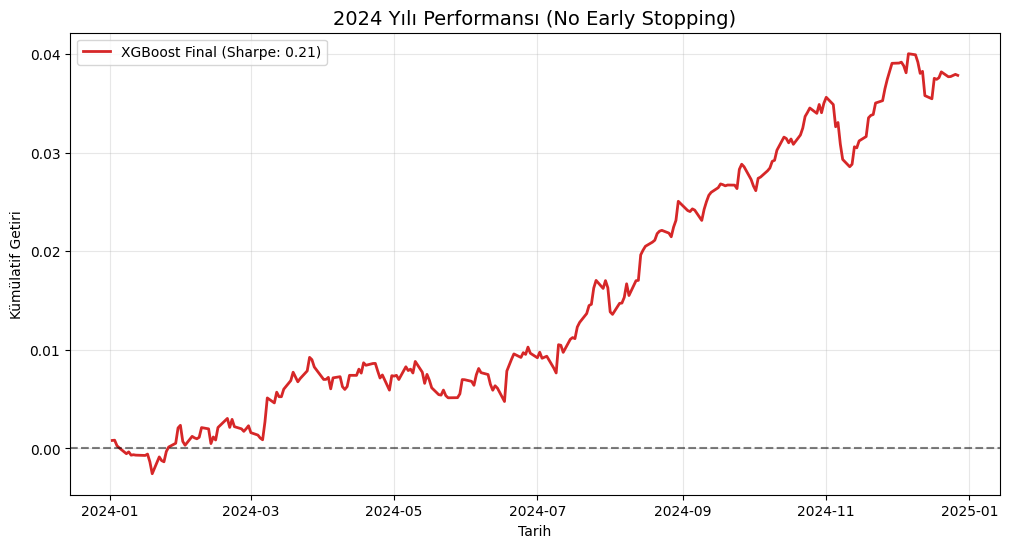

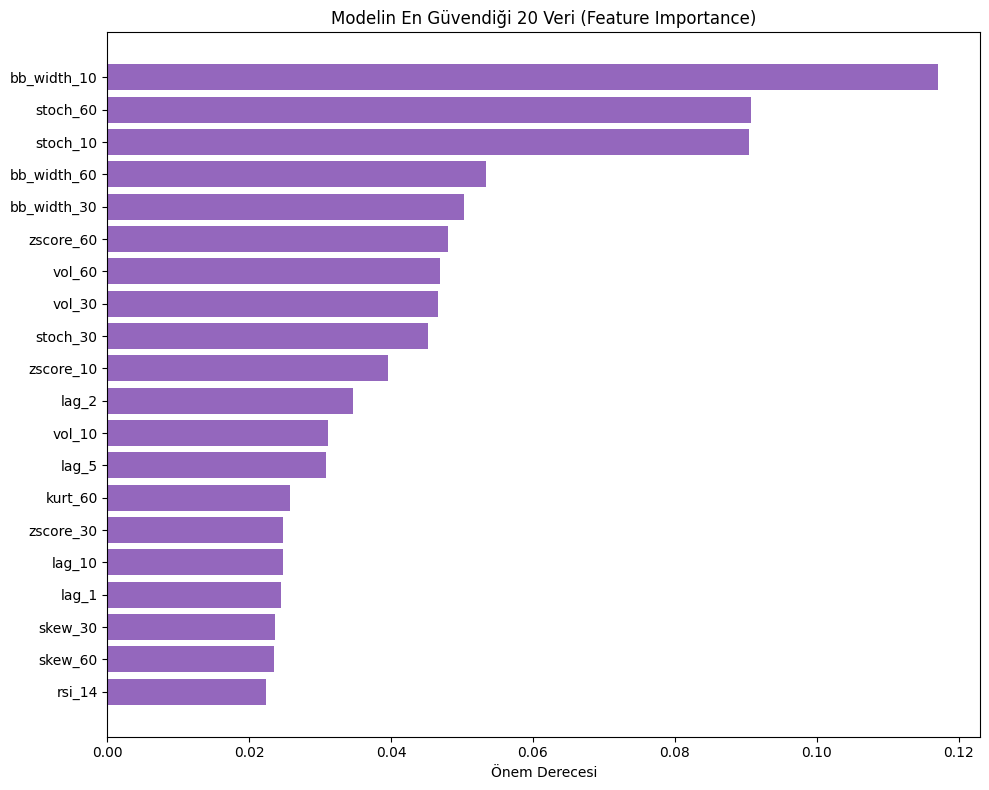

In [37]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================================
# 1. OPTUNA'DAN ÇIKAN EN İYİ PARAMETRELER (Revize Edildi)
# ==========================================================
best_params = {
    # DİKKAT: Optuna LR'yi 0.007 bulduysa, 200 ağaç yetmez. 
    # Early Stopping olmadığı için ağaç sayısını MANUEL olarak artırıyoruz.
    'n_estimators': 140,
    'learning_rate': 0.005758627734727662,
    'max_depth': 9,
    'min_child_weight': 47,
    'gamma': 0.00012889309702728672,
    'subsample': 0.8630329743440232,
    'colsample_bytree': 0.62528995188944,
    'reg_alpha': 3.8668313133327072,
    'reg_lambda': 2.4591429950315464,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}

# Optuna'dan gelen Threshold (Eğer tanımlı değilse manuel yazıyoruz)
if 'BEST_THRESHOLD' not in locals():
    BEST_THRESHOLD = 0.00010703504447178335 # Önceki optimizasyonlarınızdan gelen değer

print("=== FINAL TEST (2024) ===")
print(f"Model Konfigürasyonu: {best_params}")
print(f"İşlem Eşiği: {BEST_THRESHOLD:.8f}")

# ==========================================================
# 2. VERİ HAZIRLIĞI (TRAIN: 2011-2023 -> TEST: 2024)
# ==========================================================
# DEĞİŞİKLİK: Validation setini iptal ettik. 
# 2023 verisini de TRAIN setine katarak modeli en güncel bilgiyle eğitiyoruz.

TEST_YEAR = 2024

# Train Maskesi: 2011'den 2024'e kadar olan HER ŞEY (2023 Dahil)
train_mask = (xgb_dataset.index.year >= 2011) & (xgb_dataset.index.year < TEST_YEAR)
X_train = xgb_dataset.loc[train_mask, feature_cols]
y_train = xgb_dataset.loc[train_mask, 'target_return']

# Test Maskesi: Sadece 2024
test_mask = (xgb_dataset.index.year == TEST_YEAR)
X_test = xgb_dataset.loc[test_mask, feature_cols]
y_test = xgb_dataset.loc[test_mask, 'target_return']

print(f"\nGenişletilmiş Eğitim Seti (2011-2023): {X_train.shape}")
print(f"Test Seti (2024)                     : {X_test.shape}")

# ==========================================================
# 3. MODEL EĞİTİMİ (TAM KAPASİTE)
# ==========================================================
print(f"\nModel Eğitiliyor... (Hedef: {best_params['n_estimators']} Ağaç)")


# Early Stopping YOK. Eval Set YOK.
final_model = xgb.XGBRegressor(**best_params)

final_model.fit(
    X_train, y_train,
    verbose=False
)

print(f"Eğitim Tamamlandı.")

# ==========================================================
# 4. TAHMİN VE PERFORMANS
# ==========================================================
print("\n2024 Tahminleri Yapılıyor...")
final_preds = final_model.predict(X_test)

# Sinyal Üretimi
signals = np.zeros_like(final_preds)
signals[final_preds > BEST_THRESHOLD] = 1   # Long
signals[final_preds < -BEST_THRESHOLD] = -1 # Short

# Getiriler
final_returns = signals * y_test.values

# Metrikler
annual_factor = np.sqrt(252)
sharpe = np.mean(final_returns) / (np.std(final_returns) + 1e-8) * annual_factor
total_ret = np.sum(final_returns)
n_trades = np.sum(signals != 0)
n_long = np.sum(signals == 1)
n_short = np.sum(signals == -1)
win_rate = np.sum(final_returns > 0) / (n_trades + 1e-8) * 100

print("\n------------------------------------------")
print(f"2024 YILI SONUÇ RAPORU (Full Training)")
print("------------------------------------------")
print(f"Sharpe Ratio      : {sharpe:.4f}")
print(f"Toplam Getiri (Log): {total_ret:.4f}")
print(f"Win Rate          : %{win_rate:.2f}")
print(f"Toplam İşlem      : {n_trades} (Long: {n_long} | Short: {n_short})")
print("------------------------------------------")

# ==========================================================
# 5. GÖRSELLEŞTİRME
# ==========================================================

# A. Kümülatif Getiri (Equity Curve)
pnl_series = pd.Series(final_returns, index=xgb_dataset.loc[test_mask].index)
daily_pnl = pnl_series.groupby(pnl_series.index).mean().cumsum()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl.index, daily_pnl.values, label=f'XGBoost Final (Sharpe: {sharpe:.2f})', color='#d62728', linewidth=2)
plt.title('2024 Yılı Performansı (No Early Stopping)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.ylabel('Kümülatif Getiri')
plt.xlabel('Tarih')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

# B. Feature Importance
plt.figure(figsize=(10, 8))
sorted_idx = final_model.feature_importances_.argsort()
# Grafik karışmaması için sadece en önemli 20 özelliği gösterelim
top_n = 20
top_idx = sorted_idx[-top_n:]
plt.barh(np.array(feature_cols)[top_idx], final_model.feature_importances_[top_idx], color='#9467bd')
plt.title(f"Modelin En Güvendiği {top_n} Veri (Feature Importance)")
plt.xlabel("Önem Derecesi")
plt.tight_layout()
plt.show()

=== 2024 YILI DETAYLI KARŞILAŞTIRMA (GÜNLÜK BAŞARI DAHİL) ===

[1/2] OU Baseline Stratejisi Hesaplanıyor...
OU Veri Seti oluşturuluyor... (Hisse: 446, Gün: 334)


100%|██████████| 446/446 [00:00<00:00, 21750.84it/s]


OU Hesabı Tamamlandı ✅

[2/2] XGBoost Stratejisi Hesaplanıyor...
XGBoost Hesabı Tamamlandı ✅

   FİNAL PERFORMANS RAPORU (2024)
Model                   OU Baseline  XGBoost ML
Sharpe Ratio                 0.9896      2.7212
Total Return (%)             1.7473      3.8561
Positive Day Ratio (%)      52.5896     54.8000
Trade Win Rate (%)          50.8010     50.8967
Max Drawdown (%)            -1.3476     -0.7019
Total Trades             59741.0000  50017.0000
Long Trades              29173.0000  21789.0000
Short Trades             30568.0000  28228.0000
Annualized Volatility        0.0176      0.0140


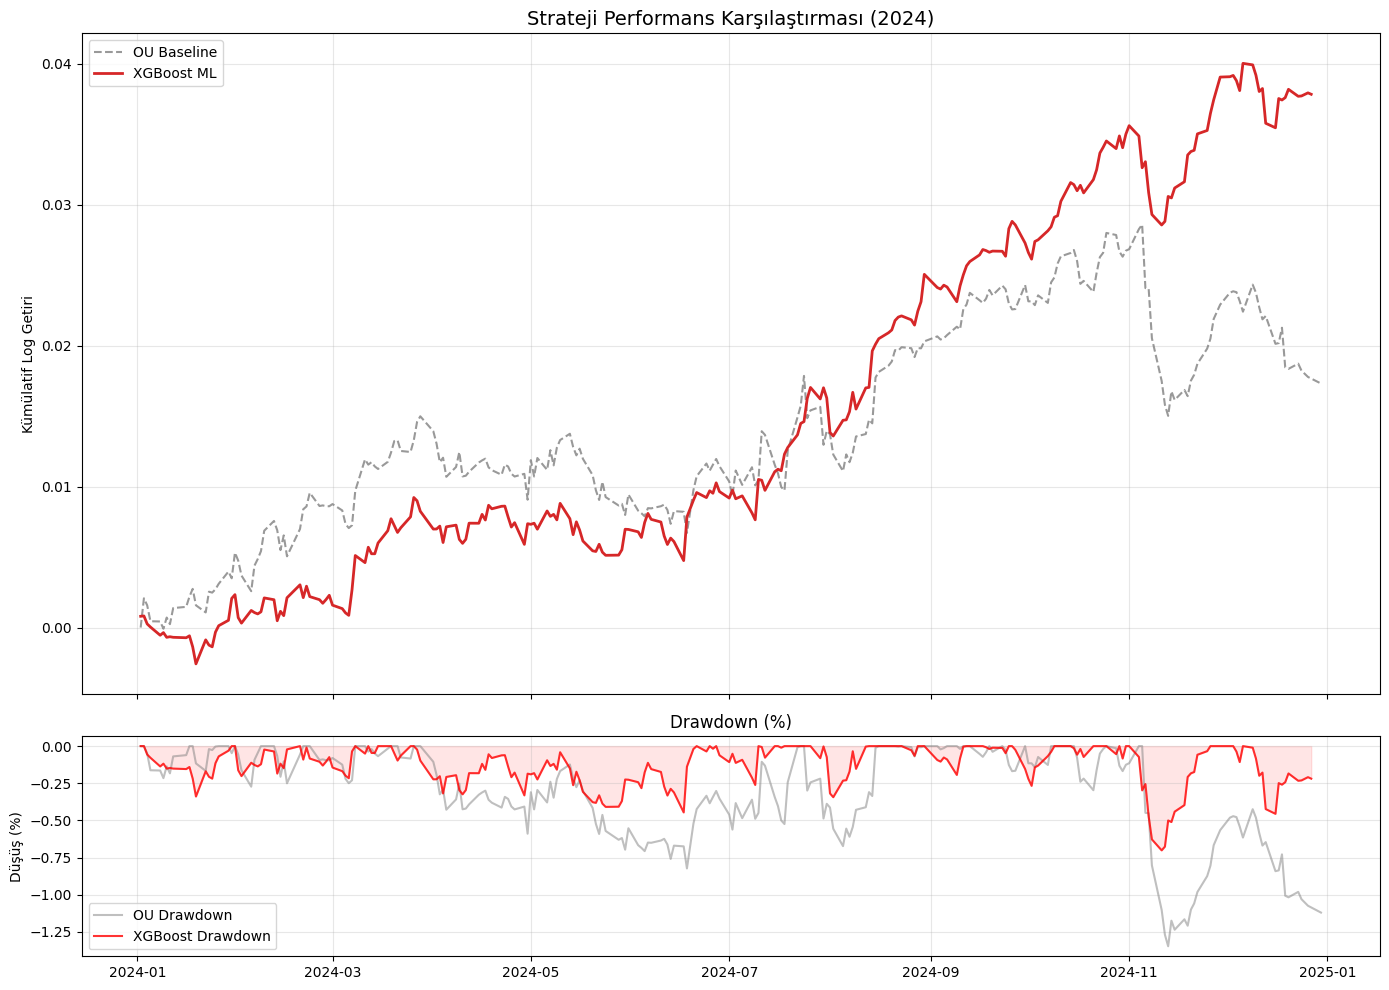

In [38]:
import matplotlib.dates as mdates
import xgboost as xgb

# ==========================================================
# 1. METRİK HESAPLAMA MOTORU (Gelişmiş + Trade Stats + Day Stats)
# ==========================================================
def calculate_comprehensive_metrics(daily_returns, signals, raw_trade_returns, name):
    """
    Hem Finansal (Portföy), hem Operasyonel (Trade), hem de Günlük Başarı metriklerini hesaplar.
    """
    if len(daily_returns) == 0:
        return {'Model': name}
    
    # --- A. PORTFÖY METRİKLERİ (Finansal) ---
    mean_ret_daily = daily_returns.mean()
    std_ret_daily  = daily_returns.std()
    total_log_ret  = daily_returns.sum()
    total_pct_ret  = (np.exp(total_log_ret) - 1) * 100
    
    # Yıllıklandırılmış
    ann_return = mean_ret_daily * 252
    ann_volatility = std_ret_daily * np.sqrt(252)
    sharpe = ann_return / (ann_volatility + 1e-9)
    
    # Max Drawdown
    cum_ret = daily_returns.cumsum()
    equity_curve = np.exp(cum_ret)
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # --- B. OPERASYONEL METRİKLER (Trade Stats) ---
    n_total_trades = np.sum(signals != 0)
    n_long         = np.sum(signals == 1)
    n_short        = np.sum(signals == -1)
    
    # Trade Win Rate (Tekil İşlem Başarısı)
    active_trades_pnl = raw_trade_returns[signals != 0]
    n_winning_trades  = np.sum(active_trades_pnl > 0)
    trade_win_rate = (n_winning_trades / n_total_trades * 100) if n_total_trades > 0 else 0
    
    # --- C. GÜNLÜK İSTATİSTİKLER (Day Stats - YENİ EKLENDİ) ---
    # Günlük getirinin 0'dan büyük olduğu günlerin oranı
    n_positive_days = (daily_returns > 0).sum()
    n_total_days = len(daily_returns)
    positive_day_ratio = (n_positive_days / n_total_days * 100) if n_total_days > 0 else 0
    
    return {
        'Model': name,
        'Sharpe Ratio': sharpe,
        'Total Return (%)': total_pct_ret,
        'Positive Day Ratio (%)': positive_day_ratio, # YENİ METRİK
        'Trade Win Rate (%)': trade_win_rate,
        'Max Drawdown (%)': max_drawdown,
        'Total Trades': int(n_total_trades),
        'Long Trades': int(n_long),
        'Short Trades': int(n_short),
        'Annualized Volatility': ann_volatility
    }

# ==========================================================
# 2. OU BASELINE HESAPLAMASI (2024 Test Yılı)
# ==========================================================
print("=== 2024 YILI DETAYLI KARŞILAŞTIRMA (GÜNLÜK BAŞARI DAHİL) ===")
TEST_YEAR = 2024
WINDOW_SIZE = 30

print("\n[1/2] OU Baseline Stratejisi Hesaplanıyor...")

test_start_date = f"{TEST_YEAR}-01-01"
test_end_date   = f"{TEST_YEAR}-12-31"
buffer_start_date = pd.to_datetime(test_start_date) - pd.DateOffset(months=4)

if not isinstance(residuals_df.index, pd.DatetimeIndex):
    residuals_df.index = pd.to_datetime(residuals_df.index)
    
df_ou_test = residuals_df.loc[buffer_start_date : test_end_date]

try:
    X_ou, y_ou = create_ou_sequences(df_ou_test, window_size=WINDOW_SIZE)
    ou_preds, ou_actuals = ou_model_predict(X_ou, y_ou, c_thresh=1, c_crit=0.05)
    
    ou_signals = ou_preds 
    ou_period_returns = ou_signals * ou_actuals
    
    valid_dates_ou = df_ou_test.index[WINDOW_SIZE:] 
    num_stocks = df_ou_test.shape[1]
    
    limit = len(ou_period_returns)
    date_index_ou = np.tile(valid_dates_ou, num_stocks)[:limit]
    
    df_pnl_ou = pd.DataFrame({
        'Date': date_index_ou, 
        'Return': ou_period_returns,
        'Signal': ou_signals.flatten()
    })
    
    df_pnl_ou = df_pnl_ou[df_pnl_ou['Date'].dt.year == TEST_YEAR]
    
    ou_daily_returns = df_pnl_ou.groupby('Date')['Return'].mean()
    ou_signals_2024 = df_pnl_ou['Signal'].values
    ou_raw_returns_2024 = df_pnl_ou['Return'].values
    
    print("OU Hesabı Tamamlandı ✅")
    
except NameError:
    print("HATA: OU fonksiyonları tanımlı değil.")
    ou_daily_returns = pd.Series(dtype=float)
    ou_signals_2024 = np.array([])
    ou_raw_returns_2024 = np.array([])

# ==========================================================
# 3. XGBOOST MODEL HESAPLAMASI (2024 Test Yılı)
# ==========================================================
print("\n[2/2] XGBoost Stratejisi Hesaplanıyor...")

if 'final_model' not in locals():
    print("UYARI: 'final_model' bulunamadı.")
    xgb_daily_returns = pd.Series(dtype=float)
    xgb_signals_2024 = np.array([])
    xgb_raw_returns_2024 = np.array([])
else:
    test_mask_xgb = (xgb_dataset.index.year == TEST_YEAR)
    X_xgb_test = xgb_dataset.loc[test_mask_xgb, feature_cols]
    y_xgb_test = xgb_dataset.loc[test_mask_xgb, 'target_return']

    xgb_raw_preds = final_model.predict(X_xgb_test)

    if 'BEST_THRESHOLD' not in locals(): BEST_THRESHOLD = 6.8839e-05
    xgb_signals = np.zeros_like(xgb_raw_preds)
    xgb_signals[xgb_raw_preds > BEST_THRESHOLD] = 1
    xgb_signals[xgb_raw_preds < -BEST_THRESHOLD] = -1

    xgb_returns = xgb_signals * y_xgb_test.values

    pnl_series_xgb = pd.Series(xgb_returns, index=xgb_dataset.loc[test_mask_xgb].index)
    xgb_daily_returns = pnl_series_xgb.groupby(pnl_series_xgb.index).mean()
    
    xgb_signals_2024 = xgb_signals
    xgb_raw_returns_2024 = xgb_returns
    
    print("XGBoost Hesabı Tamamlandı ✅")

# ==========================================================
# 4. TABLO VE RAPORLAMA
# ==========================================================
metrics_ou = calculate_comprehensive_metrics(ou_daily_returns, ou_signals_2024, ou_raw_returns_2024, "OU Baseline")
metrics_xgb = calculate_comprehensive_metrics(xgb_daily_returns, xgb_signals_2024, xgb_raw_returns_2024, "XGBoost ML")

df_compare_detailed = pd.DataFrame([metrics_ou, metrics_xgb])

# Sütun Sıralaması (Positive Day Ratio eklendi)
cols_order = [
    'Model', 
    'Sharpe Ratio', 
    'Total Return (%)', 
    'Positive Day Ratio (%)',
    'Trade Win Rate (%)', 
    'Max Drawdown (%)', 
    'Total Trades',       
    'Long Trades',        
    'Short Trades',
    'Annualized Volatility'
]
df_compare_detailed = df_compare_detailed[cols_order]

print("\n" + "="*60)
print(f"   FİNAL PERFORMANS RAPORU ({TEST_YEAR})")
print("="*60)
pd.set_option('display.float_format', '{:.4f}'.format)
print(df_compare_detailed.set_index('Model').T) 

# ==========================================================
# 5. GÖRSELLEŞTİRME
# ==========================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Kümülatif Getiri
cum_ou = ou_daily_returns.cumsum()
cum_xgb = xgb_daily_returns.cumsum()

ax1.plot(cum_ou.index, cum_ou.values, label=f"OU Baseline", color='gray', linestyle='--', alpha=0.8)
ax1.plot(cum_xgb.index, cum_xgb.values, label=f"XGBoost ML", color='#d62728', linewidth=2)
ax1.set_title(f'Strateji Performans Karşılaştırması ({TEST_YEAR})', fontsize=14)
ax1.set_ylabel('Kümülatif Log Getiri')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Drawdown
dd_ou = (np.exp(cum_ou) - np.exp(cum_ou).cummax()) / np.exp(cum_ou).cummax() * 100
dd_xgb = (np.exp(cum_xgb) - np.exp(cum_xgb).cummax()) / np.exp(cum_xgb).cummax() * 100

ax2.plot(dd_ou.index, dd_ou.values, label="OU Drawdown", color='gray', alpha=0.5)
ax2.plot(dd_xgb.index, dd_xgb.values, label="XGBoost Drawdown", color='red', alpha=0.8)
ax2.fill_between(dd_xgb.index, dd_xgb.values, 0, color='red', alpha=0.1) 
ax2.set_title('Drawdown (%)', fontsize=12)
ax2.set_ylabel('Düşüş (%)')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower left')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()